This notbook includes all of the code that generates the data and plots from the paper "Revisiting Compactness for District Plans."

In [1]:
import matplotlib.pyplot as plt

from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain, tree,
                        updaters, constraints, accept)
from gerrychain.proposals import recom
from gerrychain.metrics import polsby_popper

from functools import partial
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import geopandas as gpd
import networkx as nx
import shapely
from shapely.geometry import Point
import random
from itertools import combinations
from collections import defaultdict
import warnings
import json
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
fips_to_state = {
    "01": "AL",  # Alabama
    "02": "AK",  # Alaska
    "04": "AZ",  # Arizona
    "05": "AR",  # Arkansas
    "06": "CA",  # California
    "08": "CO",  # Colorado
    "09": "CT",  # Connecticut
    "10": "DE",  # Delaware
    "11": "DC",  # District of Columbia
    "12": "FL",  # Florida
    "13": "GA",  # Georgia
    "15": "HI",  # Hawaii
    "16": "ID",  # Idaho
    "17": "IL",  # Illinois
    "18": "IN",  # Indiana
    "19": "IA",  # Iowa
    "20": "KS",  # Kansas
    "21": "KY",  # Kentucky
    "22": "LA",  # Louisiana
    "23": "ME",  # Maine
    "24": "MD",  # Maryland
    "25": "MA",  # Massachusetts
    "26": "MI",  # Michigan
    "27": "MN",  # Minnesota
    "28": "MS",  # Mississippi
    "29": "MO",  # Missouri
    "30": "MT",  # Montana
    "31": "NE",  # Nebraska
    "32": "NV",  # Nevada
    "33": "NH",  # New Hampshire
    "34": "NJ",  # New Jersey
    "35": "NM",  # New Mexico
    "36": "NY",  # New York
    "37": "NC",  # North Carolina
    "38": "ND",  # North Dakota
    "39": "OH",  # Ohio
    "40": "OK",  # Oklahoma
    "41": "OR",  # Oregon
    "42": "PA",  # Pennsylvania
    "44": "RI",  # Rhode Island
    "45": "SC",  # South Carolina
    "46": "SD",  # South Dakota
    "47": "TN",  # Tennessee
    "48": "TX",  # Texas
    "49": "UT",  # Utah
    "50": "VT",  # Vermont
    "51": "VA",  # Virginia
    "53": "WA",  # Washington
    "54": "WV",  # West Virginia
    "55": "WI",  # Wisconsin
    "56": "WY",  # Wyoming
    "72": "PR"  # Puerto Rico
}
state_to_fips = {v: k for k, v in fips_to_state.items()}

In [3]:
# list of (state-fips-code, number of districts) that we'll consider
to_do_list = [
('37', 13), # NC congressional
('37', 50), # NC state senate
('37', 120), # NC state house
('42', 17), # PA congressional
('42', 50), # PA state senate
('42', 203), # PA state house
('39', 16), # OH congressional
('39', 33), # OH state senate
('39', 99), # OH state house
('12', 27), # FL congressional
('12', 40), # FL state senate
('12', 120), # FL state house
]

First, we build a function that calculated the Euclidean distance between the endpoints of the curve along which a pair of precincts intersects.

In [5]:
# Helper function to add_cfd.

def start_and_end_points(L):
    """
    Args 
        L: shapely MultiLineString
    Returns
        list of (startpoint, endpoint) for each segment in the MultiLineString 
    """
    # The shapely intersection of two precints is a MultiLineString whose component LineStrings might not be 
    # ordered consecutively along a connected path (even when the intersection is a single connected path).
     
    # First create a dictionary matching each point to the list of indices of line segments that start or end at that point
    # and a reverse dictionary matching each line segment to its start and end points.
    endpoints_to_segments = defaultdict(list) # dictionary with the empty list as the default value.
    segments_to_endpoints = {}
    for i, line in enumerate(L.geoms):
        start, end = tuple(line.coords[0]), tuple(line.coords[-1])
        endpoints_to_segments[start].append(i)
        endpoints_to_segments[end].append(i)
        segments_to_endpoints[i] = (start, end)
    to_return = [] 
    while True:
        # find the next (startpoint, endpoint) to add to to_return
        start_points = [point for point, segments in endpoints_to_segments.items() if len(segments) == 1]
        if len(start_points)==0:
            break 
        initial_start_point = start_points[0]
        start_point = initial_start_point
        done = False        
        while not done:
            segment = endpoints_to_segments.pop(start_point)[0]
            l = segments_to_endpoints[segment]
            end_point = l[1] if l[0] == start_point else l[0]
            #print(f"start = {start_point}, end = {end_point}, segement = {segment}")
            del segments_to_endpoints[segment]
            endpoints_to_segments[end_point].remove(segment)
            # If the end point is now isolated, remove it from the dictionary
            if len(endpoints_to_segments[end_point])==0:
                del endpoints_to_segments[end_point]
                to_return.append((initial_start_point, end_point))
                done = True
            elif len(endpoints_to_segments[end_point])!=1:
                to_return.append((initial_start_point, end_point))
                done = True
            else:
                start_point = end_point
    return to_return

def add_cfd(graph, verbose = True):
    """
    add 'cfd' edge attribute to the graph
    (crow fly distance = Euclidean distance between the endpoints of the shared boundary)
    If the shared boundary is not a connected path, then the cdf is summed over its connected components      
    """
    for e in graph.edges:
        i_collection = shapely.intersection(graph.geometry[e[0]], graph.geometry[e[1]])

        # make it a collection so we can iterate over it
        if type(i_collection) != shapely.geometry.collection.GeometryCollection:
            i_collection = shapely.geometry.GeometryCollection([i_collection])

        cfd = 0
        for i in i_collection.geoms:
            if type(i) == shapely.geometry.point.Point:  
                pass # don't add anything to cfd 
            elif type(i) == shapely.geometry.linestring.LineString: 
                start_point = Point(i.coords[0])
                end_point = Point(i.coords[-1])
                cfd += start_point.distance(end_point)    
            elif type(i) == shapely.geometry.multilinestring.MultiLineString:
                segments = start_and_end_points(i)
                for start_point, end_point in segments:
                    cfd += Point(start_point).distance(Point(end_point))
            else:
                raise ValueError(f"for edge {e}, a component of the intersection has type {type(i)}")

        perim = graph.edges[e]['shared_perim']
        if cfd > perim:
            if verbose:
                print(f"edge {e} has cfd = {cfd} > perim = {perim}")
            cfd = perim
        if cfd == 0: # this happens when the intersection is one closed loop, which is rare.
            if verbose:
                print(f"edge {e} has cfd = 0")
            cfd = perim
        graph.edges[e]['cfd'] = cfd

The following functions takes a gerrychain graph and adds edge attributes corresponsing to some of the measurements used in the paper.

In [6]:
def add_graph_attributes(graph):
    """
    Add graph edge attribues: 
    ['cfd', 'Perimeter', 'Slack', 'Standard ReCom', 'phi', 'root_phi',
    'Conformal perimeter', 'Conformal linear perimeter',
    'County weight', 'County weight 01']
    """
    add_cfd(graph, verbose = False)
    for e in graph.edges:
        graph.edges[e]['Perimeter']=graph.edges[e]['shared_perim']
        graph.edges[e]['Slack'] = graph.edges[e]['shared_perim']/graph.edges[e]['cfd'] - 1
        graph.edges[e]['Standard ReCom'] = 1
        perim = graph.edges[e]['Perimeter']
        cfd = graph.edges[e]['cfd']
        area0 = graph.nodes[e[0]]['area']
        area1 = graph.nodes[e[1]]['area']
        pop0 = graph.nodes[e[0]]['TOTPOP']
        pop1 = graph.nodes[e[1]]['TOTPOP']
        phi = (pop0+pop1)/(area0+area1)

        graph.edges[e]['phi'] = phi
        graph.edges[e]['root_phi'] = np.sqrt(phi)

        conformal_perim = perim * np.sqrt(phi)
        graph.edges[e]['Conformal perimeter'] = conformal_perim

        clp = cfd * np.sqrt(phi)
        graph.edges[e]['Conformal linear perimeter'] = clp

        county_weight = 20 if graph.nodes[e[0]]['County'] == graph.nodes[e[1]]['County'] else 1
        graph.edges[e]['County weight'] = county_weight

        county_weight_01 = 0 if graph.nodes[e[0]]['County'] == graph.nodes[e[1]]['County'] else 1
        graph.edges[e]['County weight 01'] = county_weight_01

In [7]:
def corr_table(graph, columns = ['County weight 01', 'Perimeter', 'Slack', 'phi']):
    """
    return a table of correlations between (some of) the attributes of the edges of the given graph     
    """
    db_edges = pd.DataFrame(columns=columns)
    for e in graph.edges(data=True):
        row_num = db_edges.shape[0]
        db_edges.loc[row_num] = [e[2][col] for col in columns]
    return db_edges.corr().round(2)

The following function builds a random spanning tree using the weighted version of Kruskal discussed in the paper.

In [8]:
def weighted_mst(graph, edge_label):
    """
    Builds a spanning tree chosen by Kruskal's method.
    The weight of each edge e is randomly chosen from the interval [-edge_label,0].
    """
    for edge in graph.edges():
        weight = -1*random.random()*(graph.edges[edge][edge_label])
        graph.edges[edge]["random_weight"] = weight

    spanning_tree = nx.tree.minimum_spanning_tree(
        graph, algorithm="kruskal", weight="random_weight"
    )
    return spanning_tree

The following function runs a ReCom chain.  The Kruskal_weight parameter should be one of ['Standard ReCom', 'County weight', 'Perimeter', 'Slack'], corresponding to the weighting methods in the paper, or 'all' to run one chain for each of these methods.  It doesn't save the ensemble, but only saves a dataframe containing the relevant scores for each map in the ensemble.  If desired, it also saves the correlation table (Table 1 in the paper).

It uses the shapefiles in the VTD_shapefiles folder and the initial seed plans in the Initial_assignments folder. 

In [ ]:
# Buld and save an ensemble of the given length for the given state-chamber pair.
# Saves a dataframe with several scores for each partition in the ensemble.
def Build_ensemble(fips, num_districts, num_steps=50000, Kruskal_weight = 'all', make_corr_table = False):
    print(f"****Working on {fips}={fips_to_state[fips]} with {num_districts} districts****")
    filename = f"VTD_shapefiles/{fips}_vtd_2020.geoJSON"
    gdata = gpd.read_file(filename)
    gdata = gdata.rename(columns={'p1_001n': 'TOTPOP', 'COUNTYFP20': 'County'})
    graph = Graph.from_geodataframe(gdata, ignore_errors=True, cols_to_add=['TOTPOP', 'County'])
    add_graph_attributes(graph)

    # create correlation table
    if make_corr_table:
        T = corr_table(graph)
        T.to_csv(f"Corr_tables/{fips}_corr_table.csv")

    # Create a dictionary mapping precincts at the edge of the state to the conformal perimeter of their exterior edges.
    # This will be necessary to compute the Conformal Polsby-Popper score.
    state_edge_dict = {}
    for node in graph.nodes:
        if graph.nodes[node]['boundary_node']:
            phi = graph.nodes[node]['TOTPOP']/graph.nodes[node]['area']
            perim = graph.nodes[node]['boundary_perim']
            state_edge_dict[node] = perim*np.sqrt(phi)    

    # Construct updaters and initial partition
    my_updaters = {"population": updaters.Tally("TOTPOP", alias="population"),
                "cut_edges": updaters.cut_edges}

    def perim(partition):
        return sum(graph.edges[e]['Perimeter'] for e in partition["cut_edges"])

    def conformal_perim(partition):
        return sum(graph.edges[e]['Conformal perimeter'] for e in partition["cut_edges"])

    def conformal_linear_perim(partition):
        return sum(graph.edges[e]['Conformal linear perimeter'] for e in partition["cut_edges"])

    def num_county_edges(partition):
        return len([e for e in partition["cut_edges"] if graph.edges[e]['County weight'] == 1]) 

    def Conformal_Polsby_Popper(partition):
        """
        Returns dictionary mapping district ID to conformal Polsby-Popper score.  
        """
        conformal_areas = partition['population'] # dictionary mapping district ID to conformal area
        conformal_perimeters = {part:0 for part in partition.parts} # dictionary mapping district ID to conformal perimeter
        for e in partition['cut_edges']:
            node0, node1 = partition.assignment[e[0]], partition.assignment[e[1]]
            conformal_perimeters[node0] += graph.edges[e]['Conformal perimeter']
            conformal_perimeters[node1] += graph.edges[e]['Conformal perimeter']
        for node, conf_perim in state_edge_dict.items():
            conformal_perimeters[partition.assignment[node]] += conf_perim
        return {part: (4*np.pi*conformal_areas[part])/(conformal_perimeters[part]**2) for part in partition.parts}

    def Conformal_Polsby_Popper_score(partition):
        return sum(Conformal_Polsby_Popper(partition).values())/len(Conformal_Polsby_Popper(partition))

    my_updaters.update({"Total perimeter": perim,
                        "Total conformal perimeter": conformal_perim,
                        "Total conformal linear perimeter":conformal_linear_perim,
                        "County edges": num_county_edges,
                        "Conformal Polsby-Popper": Conformal_Polsby_Popper_score
                        })

    # Construct initial partition
    filename = f"Initial_assignments/{fips}_{num_districts}_initial_assignment_windows.json"
    with open(filename, 'r') as file:
        initial_assigment = json.load(file)
    initial_assigment = {int(k):v for k,v in initial_assigment.items()} #convert string keys to integers 
    initial_partition = GeographicPartition(graph=graph, assignment=initial_assigment, updaters=my_updaters)
    ideal_population = sum(initial_partition["population"].values()) / num_districts
    pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.05)

    # generate the maps of the ensembles and create a dataframe of their properties 
    if Kruskal_weight == 'all':
        Kruskal_weight_list = ['Standard ReCom', 'County weight', 'Perimeter', 'Slack']
    else:
        Kruskal_weight_list = [Kruskal_weight]
    data = pd.DataFrame(columns=["Kruskal weight", 'Cut edge count',
                                "Polsby-Popper", 'Conformal Polsby-Popper', 
                                "Total perimeter", "Total conformal perimeter", 'Total conformal linear perimeter',
                                'County edges', 'avg slack', 'avg root phi' 
                                ])
    for method in Kruskal_weight_list:
        print(method)
        proposal = partial(
        recom,
        pop_col="TOTPOP",
        pop_target=ideal_population,
        epsilon=0.05,
        node_repeats=50,
        method = partial(tree.bipartition_tree, allow_pair_reselection=True,
                        spanning_tree_fn=partial(weighted_mst, edge_label=method))
        )
        chain = MarkovChain(
            proposal=proposal,
            constraints=[pop_constraint],
            accept=accept.always_accept,
            initial_state=initial_partition,
            total_steps=num_steps
        )
        for partition in tqdm.tqdm(chain):
            row_num = data.shape[0]
            data.loc[row_num] = [
                method,
                len(partition["cut_edges"]),
                sum(polsby_popper(partition).values())/num_districts,
                partition["Conformal Polsby-Popper"],
                partition["Total perimeter"],
                partition["Total conformal perimeter"],
                partition["Total conformal linear perimeter"],
                partition["County edges"],
                sum(graph.edges[e]['Slack'] for e in partition["cut_edges"])/len(partition["cut_edges"]),
                sum(graph.edges[e]['root_phi'] for e in partition["cut_edges"])/len(partition["cut_edges"])
            ]
    if Kruskal_weight == 'all':
        filename = f"{fips}_{num_districts}_ensemble.csv"
    else:
        filename = f"{fips}_{num_districts}_ensemble_{Kruskal_weight}.csv"
        
    if num_steps == 50000:
        data.to_csv(f"dataframes_50K_ensembles/{filename}")
    elif num_steps == 5000:
        data.to_csv(f"dataframes_5K_ensembles/{filename}")
    else:
        data.to_csv(filename)

EXAMPLE OF USAGE TO CREATE FLORIDA DATAFRAMES:
```
for (fips, num_districts) in [('12', 27), ('12', 40), ('12', 120)]:
    for Kruskal_weight in ['Standard ReCom', 'County weight', 'Perimeter', 'Slack']:
        Build_ensemble(fips, num_districts, num_steps=50000, Kruskal_weight = Kruskal_weight, make_corr_table = False)
```

Outputs of such runs are saved in the folders dataframes_5K_ensembles, dataframes_50K_ensembles, and Corr_tables

In [11]:
# Let's look at the correlation tables
for fips in ['12', '37', '39', '42']:
    print(f"****{fips}={fips_to_state[fips]}")
    corr_table = pd.read_csv(f"Corr_tables/{fips}_corr_table.csv")
    print(corr_table)

****12=FL
         Unnamed: 0  County weight 01  Perimeter  Slack   phi
0  County weight 01              1.00       0.17  -0.01 -0.16
1         Perimeter              0.17       1.00   0.06 -0.28
2             Slack             -0.01       0.06   1.00 -0.02
3               phi             -0.16      -0.28  -0.02  1.00
****37=NC
         Unnamed: 0  County weight 01  Perimeter  Slack   phi
0  County weight 01              1.00       0.07  -0.12 -0.27
1         Perimeter              0.07       1.00   0.38 -0.44
2             Slack             -0.12       0.38   1.00 -0.12
3               phi             -0.27      -0.44  -0.12  1.00
****39=OH
         Unnamed: 0  County weight 01  Perimeter  Slack   phi
0  County weight 01              1.00       0.11  -0.04 -0.15
1         Perimeter              0.11       1.00   0.13 -0.34
2             Slack             -0.04       0.13   1.00 -0.03
3               phi             -0.15      -0.34  -0.03  1.00
****42=PA
         Unnamed: 0  County we

Next we'll create a Build_plot function that inputs the state fips and a list of one or more k-values, and outputs one of the following types of plots:
- plot_type = 'plots6': the six compactness scores, like Figure 5.
- plot_type = 'plots3': the three most common compactness scores, like Figure 8.
- plot_type = 'avg_plots': the four averaged scores, like Figure 9.

In [5]:
def Build_plot(fips, k_list, plot_type, size='50K', legend = True, filename = None):
    data = dict()
    K = len(k_list)
    for j, k in enumerate(k_list):
        data[j] = pd.read_csv(f"dataframes_{size}_ensembles/{fips}_{k}_ensemble.csv")
        data[j]['avg perimeter'] = data[j]['Total perimeter']/data[j]['Cut edge count']
        data[j]['County portion'] = data[j]['County edges']/data[j]['Cut edge count']
        data[j]['Ensemble type'] = data[j]['Kruskal weight']

    # make plot of six compactness scores
    if plot_type == 'plots6':
        if K != 1:
            print("Only one k allowed for this plot type")
            return
        k = k_list[0]
        data = data[0]
        fig, axes = plt.subplots(2, 4, figsize=(15, 6))
        axes = axes.flatten()
        for i, score in enumerate(['Polsby-Popper', 'Conformal Polsby-Popper']):
            leg = False if not legend else i==1
            sns.kdeplot(data=data, x=score, hue='Ensemble type', fill=True, ax=axes[i+1], legend=leg)
            axes[i].set_xlabel(score, fontsize=12)
            axes[i].yaxis.set_visible(False)
            axes[i].set_xticklabels([])  # Remove x-axis numbers
            axes[i].set_frame_on(False)
        for i, score in enumerate(['Total perimeter', 'Total conformal perimeter',
                                    'Total conformal linear perimeter', 'Cut edge count']):
            sns.kdeplot(data=data, x=score, hue='Ensemble type', fill=True, ax=axes[i+4], legend=(False))

        score_names = ['','Polsby-Popper', 'conf Polsby-Popper', '',
                    'total perim', 'total conf perim','total conf linear perim', 'cut edge count']
        for i in range(8):
            axes[i].set_xlabel(score_names[i], fontsize=12)
            axes[i].yaxis.set_visible(False)
            axes[i].set_frame_on(False)
            axes[i].set_xticklabels([])
        axes[0].remove()
        axes[3].remove()
        fig.suptitle(f"{fips_to_state[fips]} with {k} districts", fontsize=16)     

    # make plot of three compactness scores
    if plot_type == 'plots3':
        fig, axes = plt.subplots(1*K, 3, figsize=(15, 3*K))
        axes = axes.flatten()
        score_names = ['Polsby-Popper', 'Total perimeter', 'Cut edge count']
        for j, k in enumerate(k_list):
            for i, score in enumerate(score_names):
                ind = i+j*3
                leg = False if not legend else (i==2 and j == 0)
                sns.kdeplot(data=data[j], x=score, hue='Ensemble type', fill=True, ax=axes[ind], legend=leg)
                #if j == K-1:
                #    axes[ind].set_xlabel(score_names[i], fontsize=12)
                #else:
                #    axes[ind].set_xlabel('')
                axes[ind].yaxis.set_visible(False)
                #axes[ind].set_xticklabels([])  # Remove x-axis numbers
                axes[ind].set_frame_on(False)
                if i == 0:
                    axes[ind].set_title(f"{fips_to_state[fips]} with {k} districts", fontsize=20)

    # make plot of averages
    if plot_type == 'avg_plots':
        fig, axes = plt.subplots(1*K, 4, figsize=(15, 3*K))
        axes = axes.flatten()
        score_names = ['avg perimeter', 'avg slack', 'avg root phi', 'county portion']
        for j, k in enumerate(k_list):
            for i, score in enumerate(['avg perimeter', 'avg slack', 'avg root phi', 'County portion']):
                ind = i+j*4
                leg = False if not legend else (i==3 and j == 0)
                sns.kdeplot(data=data[j], x=score, hue='Ensemble type', fill=True, ax=axes[ind], legend=leg)
                #if j == K-1:
                #    axes[ind].set_xlabel(score_names[i], fontsize=12)
                #else:
                #    axes[ind].set_xlabel('')
                axes[ind].set_xlabel(score_names[i], fontsize=12)
                axes[ind].yaxis.set_visible(False)
                #axes[ind].set_xticklabels([])  # Remove x-axis numbers
                axes[ind].set_frame_on(False)
                if i == 0:
                    axes[ind].set_title(f"{fips_to_state[fips]} with {k} districts", fontsize=20)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=100)
    else:
        plt.show()

We'll demonstrate by first generating the NC plots from the paper

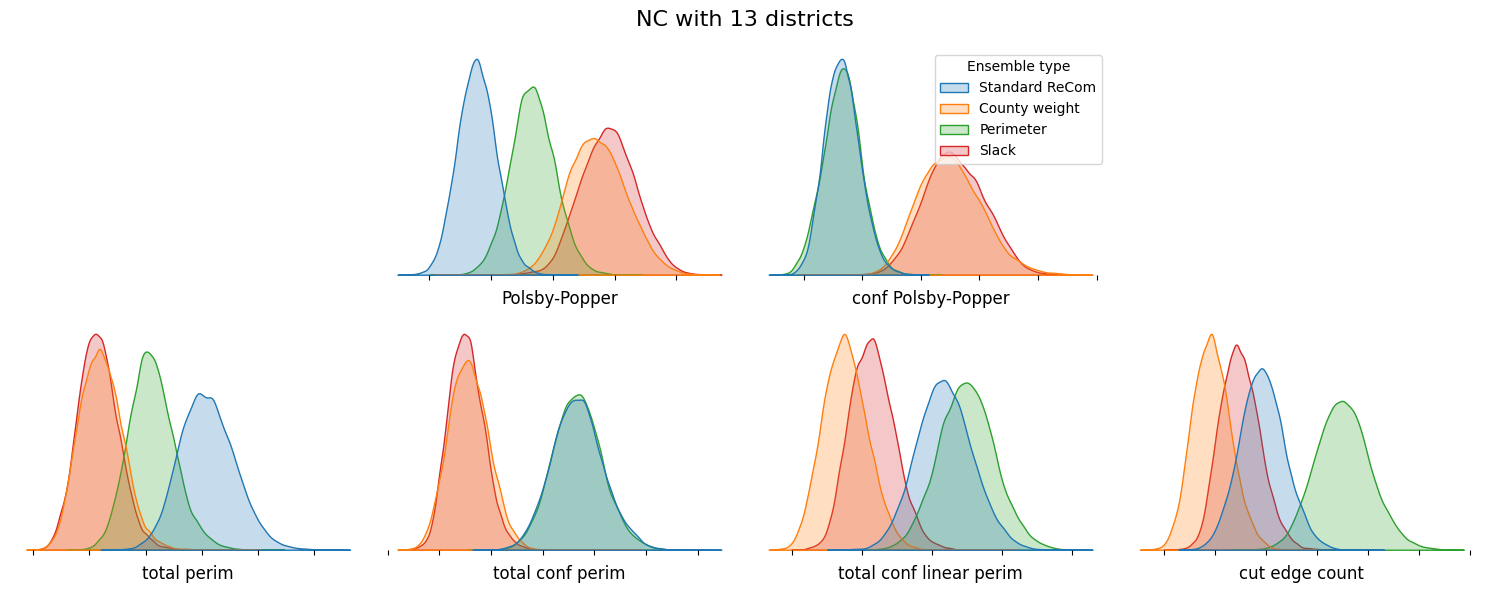

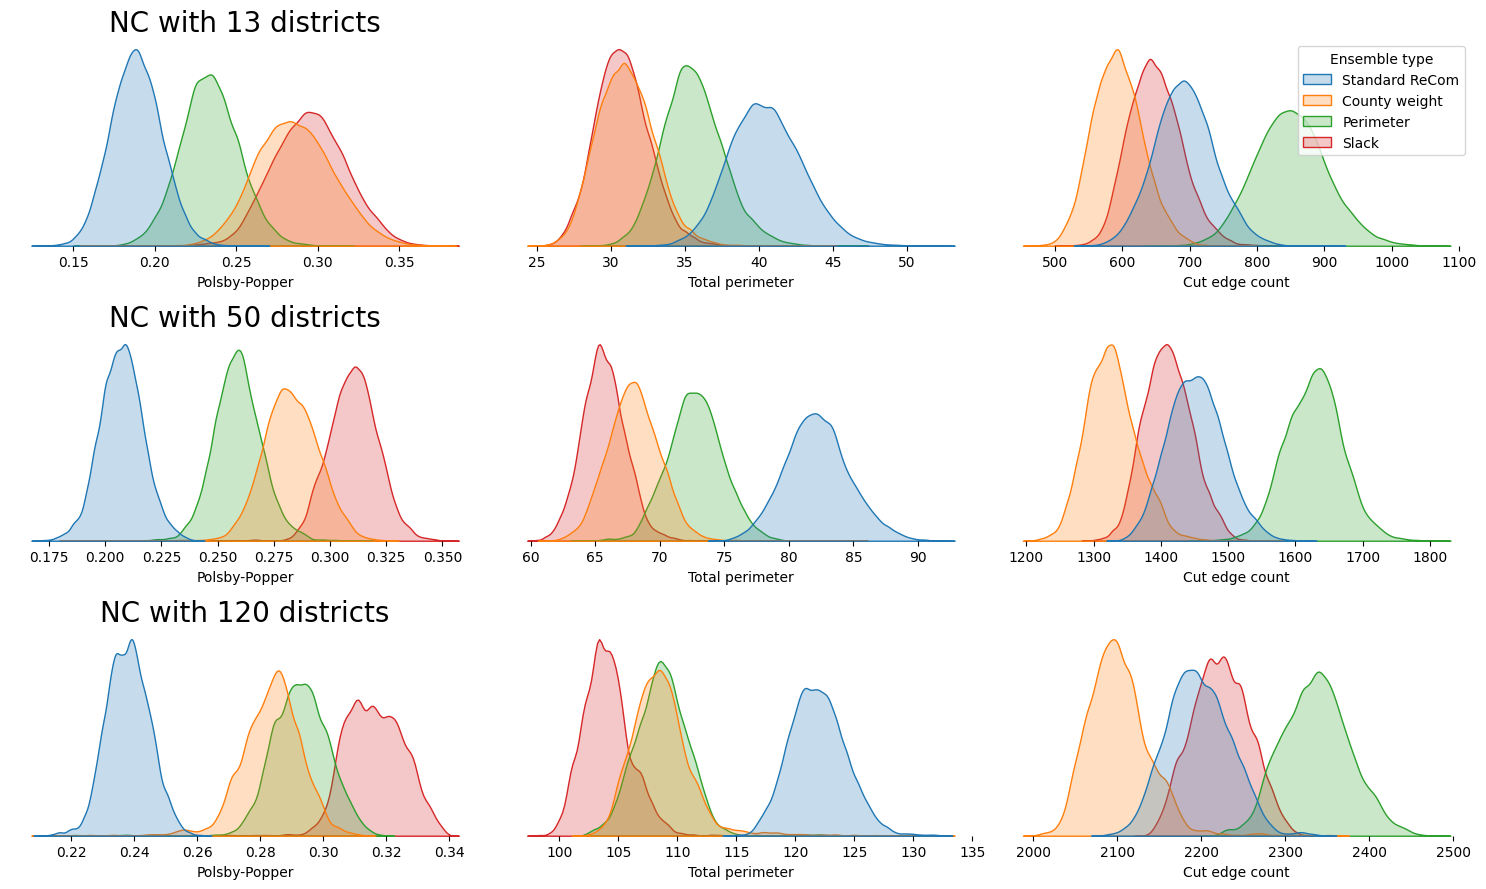

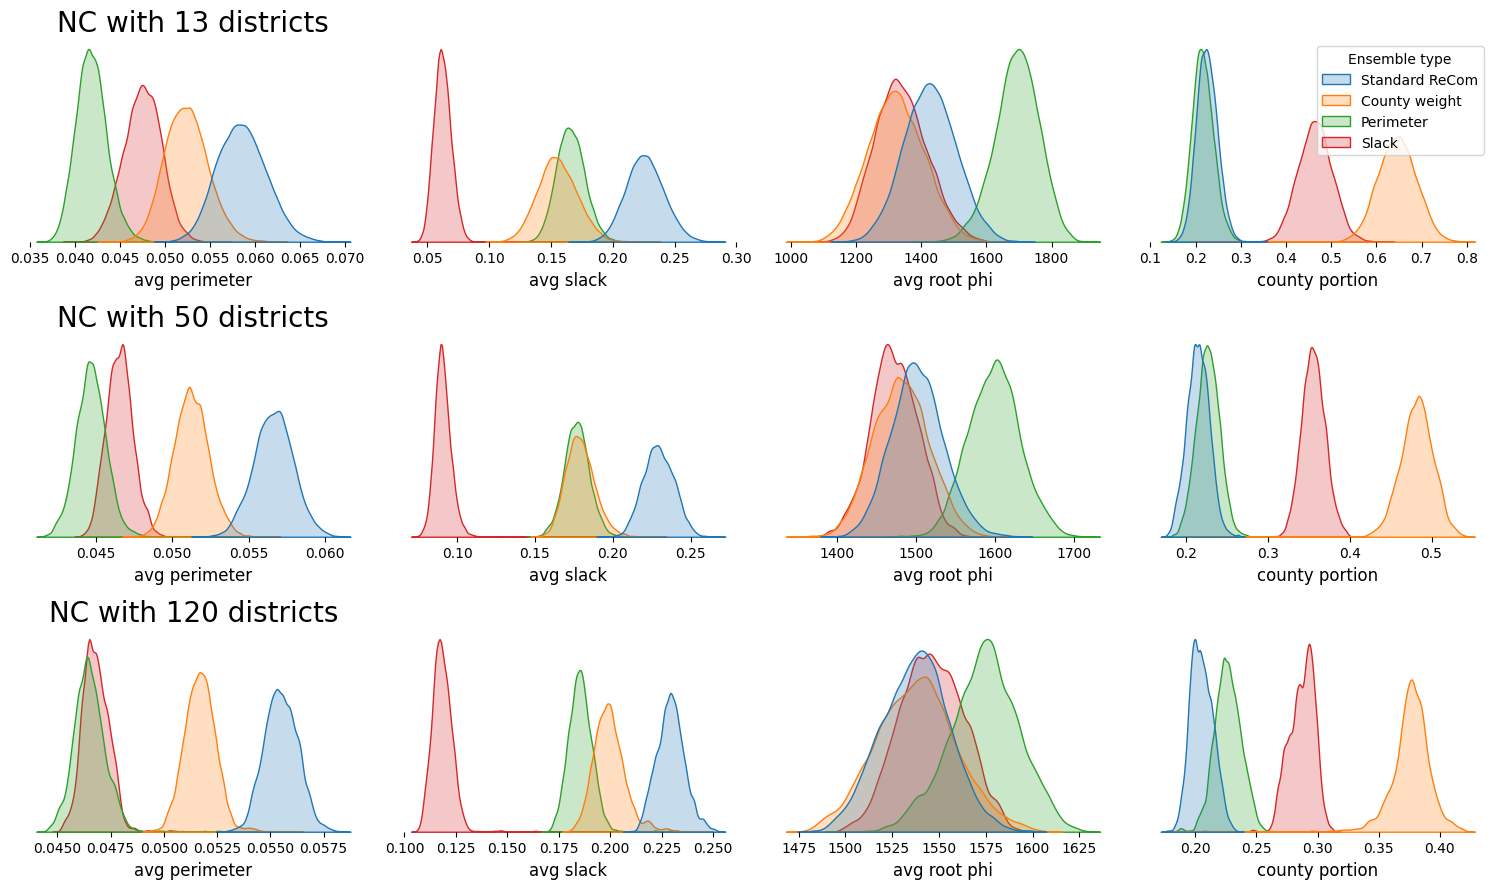

In [6]:
Build_plot('37', ['13'], plot_type = 'plots6', size='50K', legend = True, filename = 'plots/NC_congressional_compact6.png')
Build_plot('37', ['13','50','120'], plot_type = 'plots3', size='50K', legend = True, filename = 'plots/NC_all_compact3.png')
Build_plot('37', ['13','50','120'], plot_type = 'avg_plots', size='50K', legend = True, filename = 'plots/NC_all_avg4.png')

Next we'll do the same for FL, which is the only other state for which we generated the larger 50K ensembles.

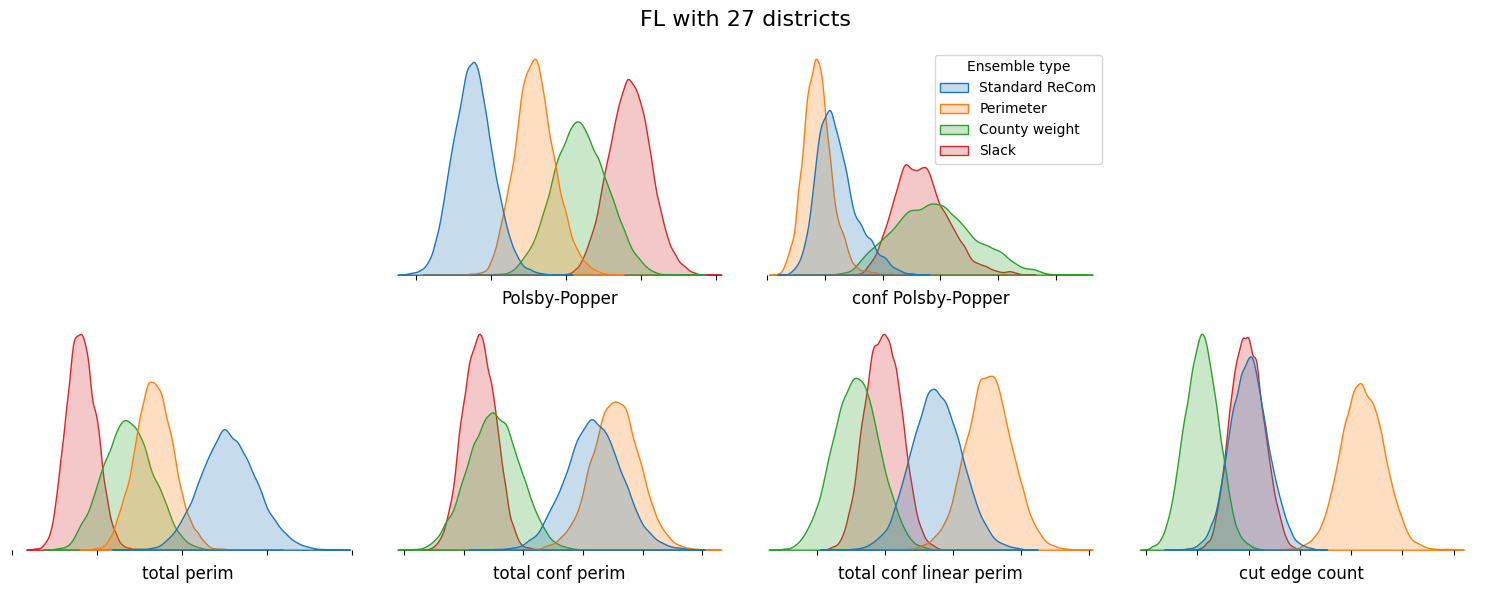

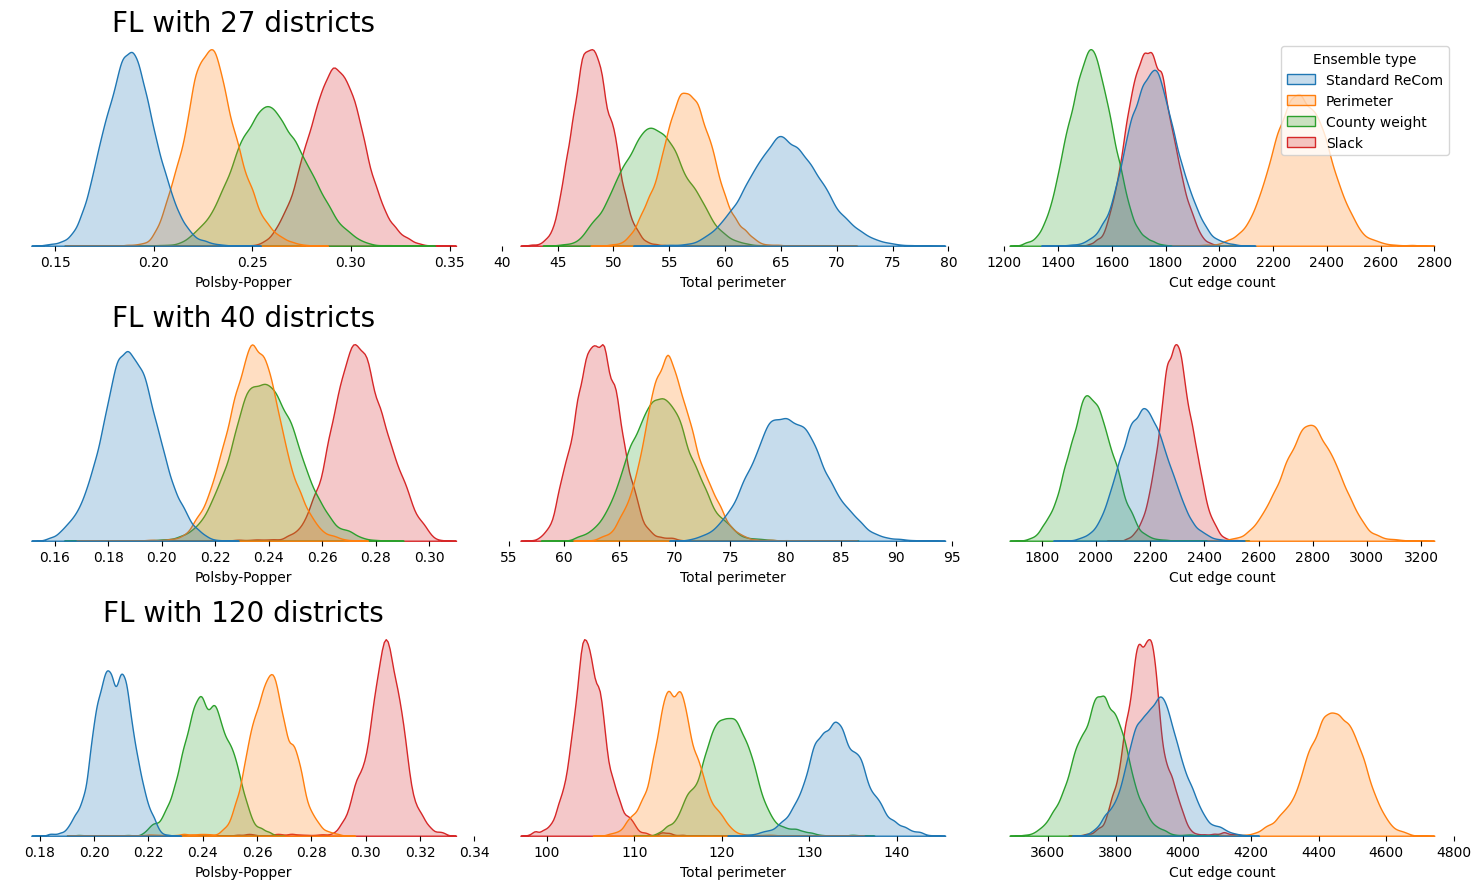

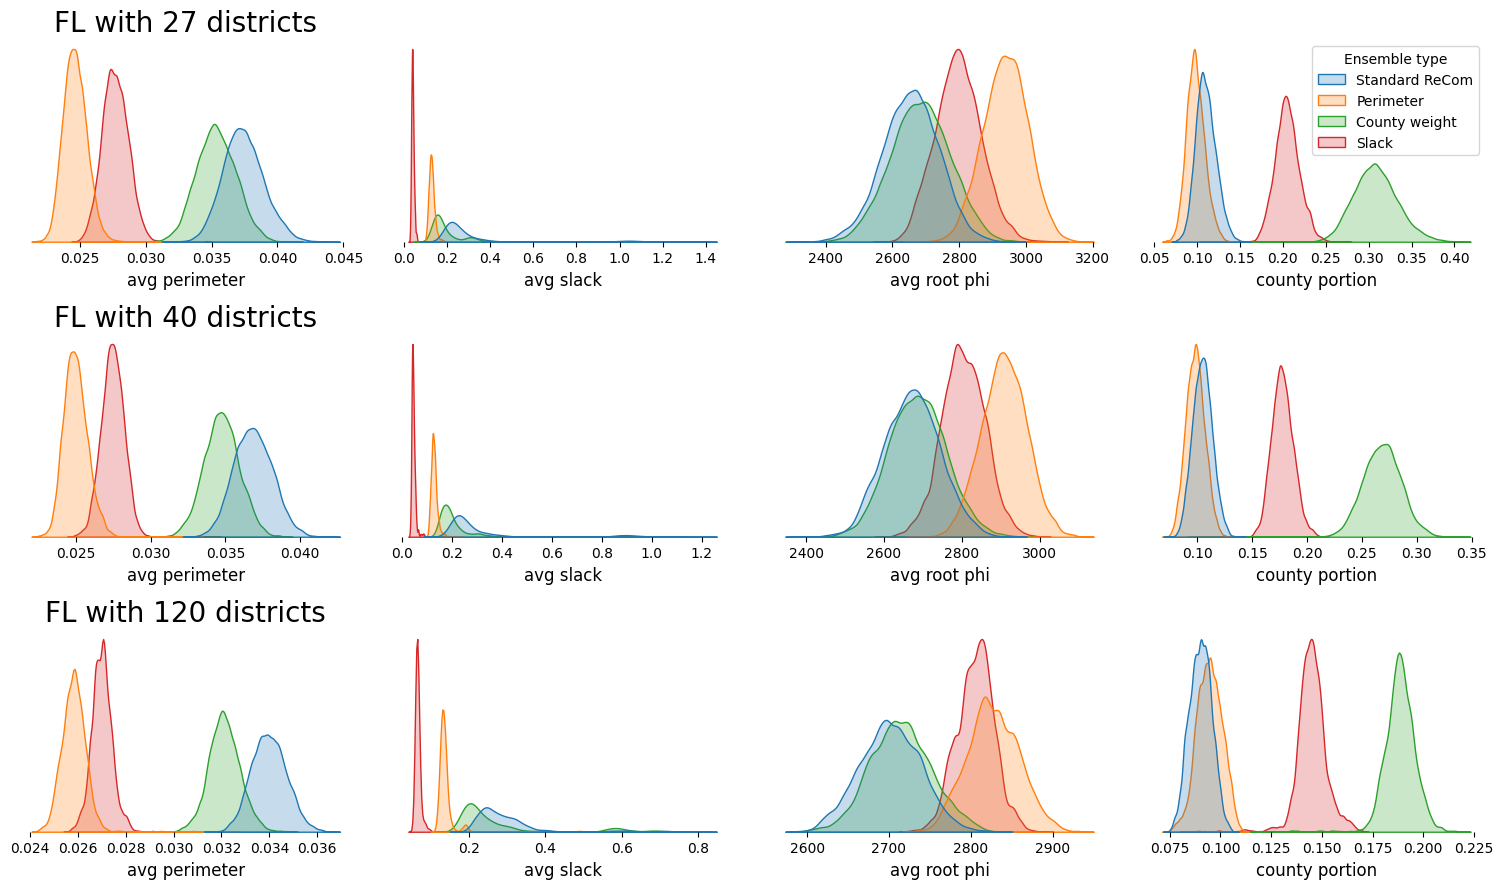

In [7]:
Build_plot('12', ['27'], plot_type = 'plots6', size='50K', legend = True, filename = 'plots/FL_congressional_compact6.png')
Build_plot('12', ['27','40','120'], plot_type = 'plots3', size='50K', legend = True, filename = 'plots/FL_all_compact3.png')
Build_plot('12', ['27','40','120'], plot_type = 'avg_plots', size='50K', legend = True, filename = 'plots/FL_all_avg4.png')

Next, we'll generate similar plots from other states.  The following uses 5K ensembles rather than 50K ensembles because they are much faster to generate.

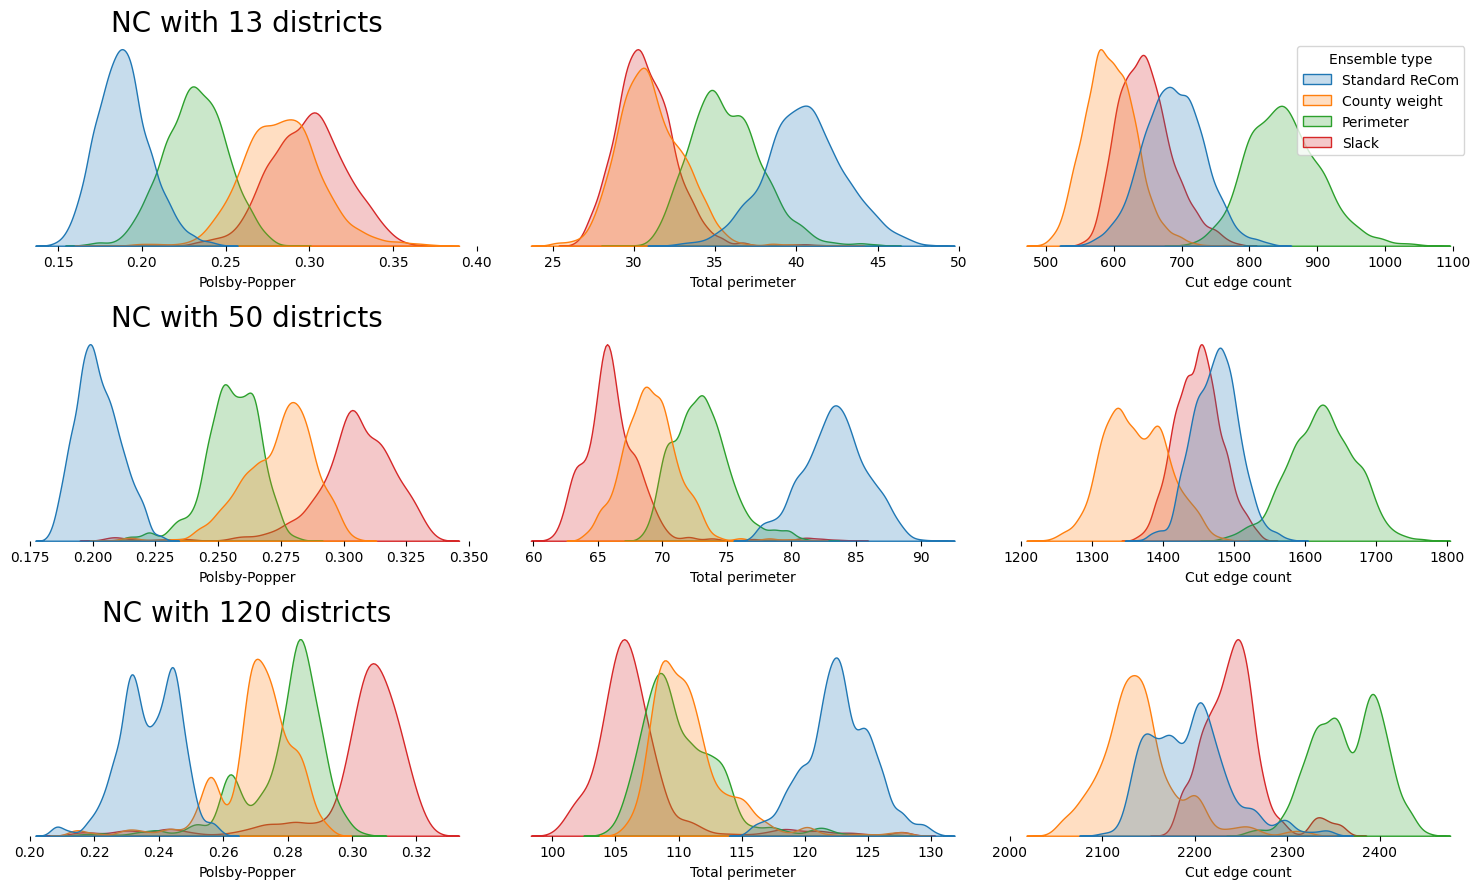

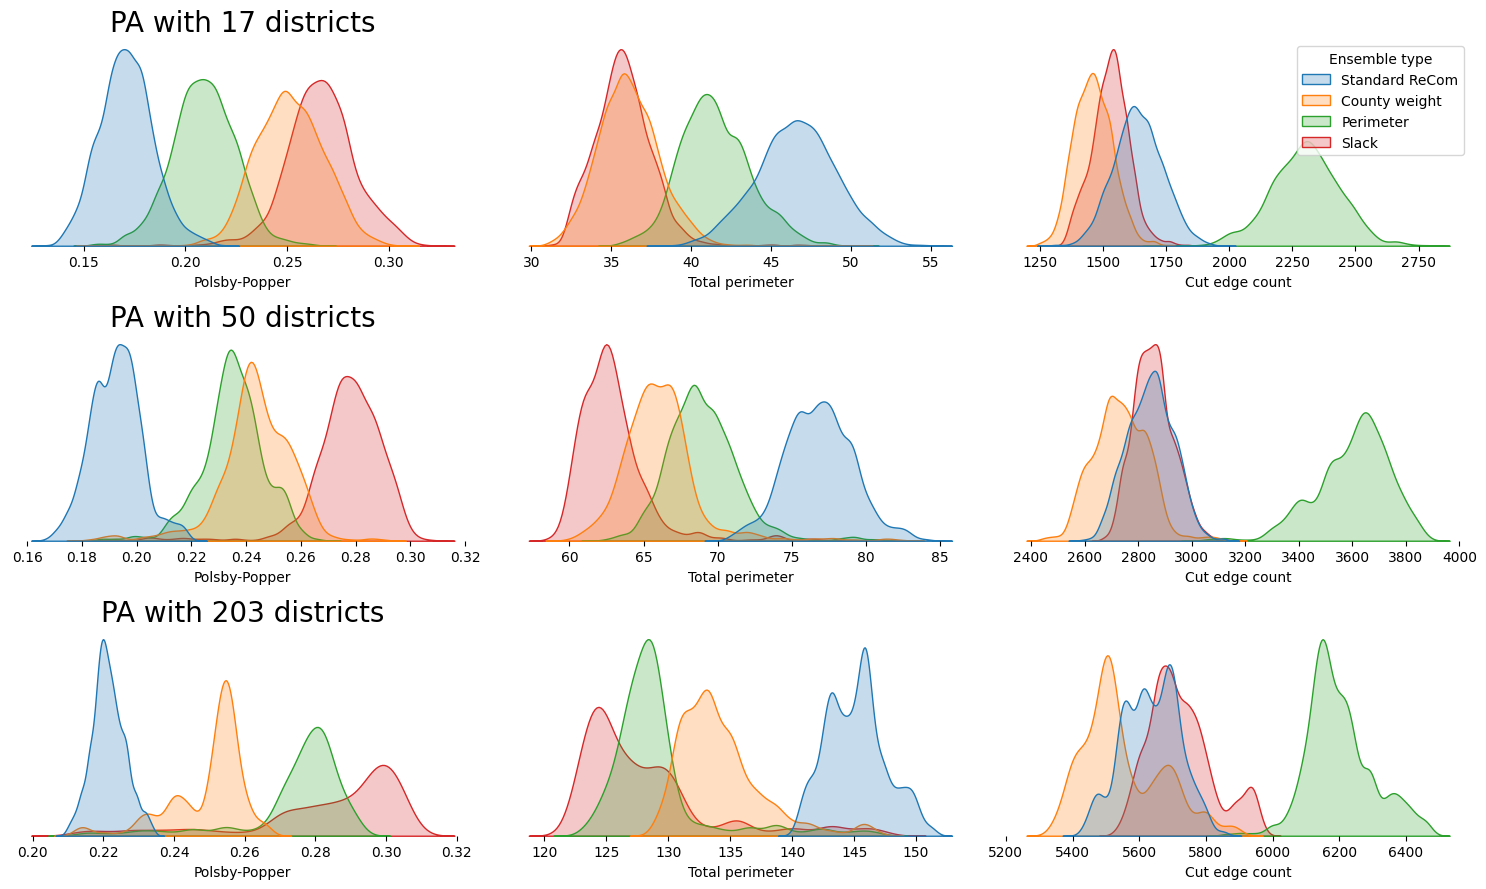

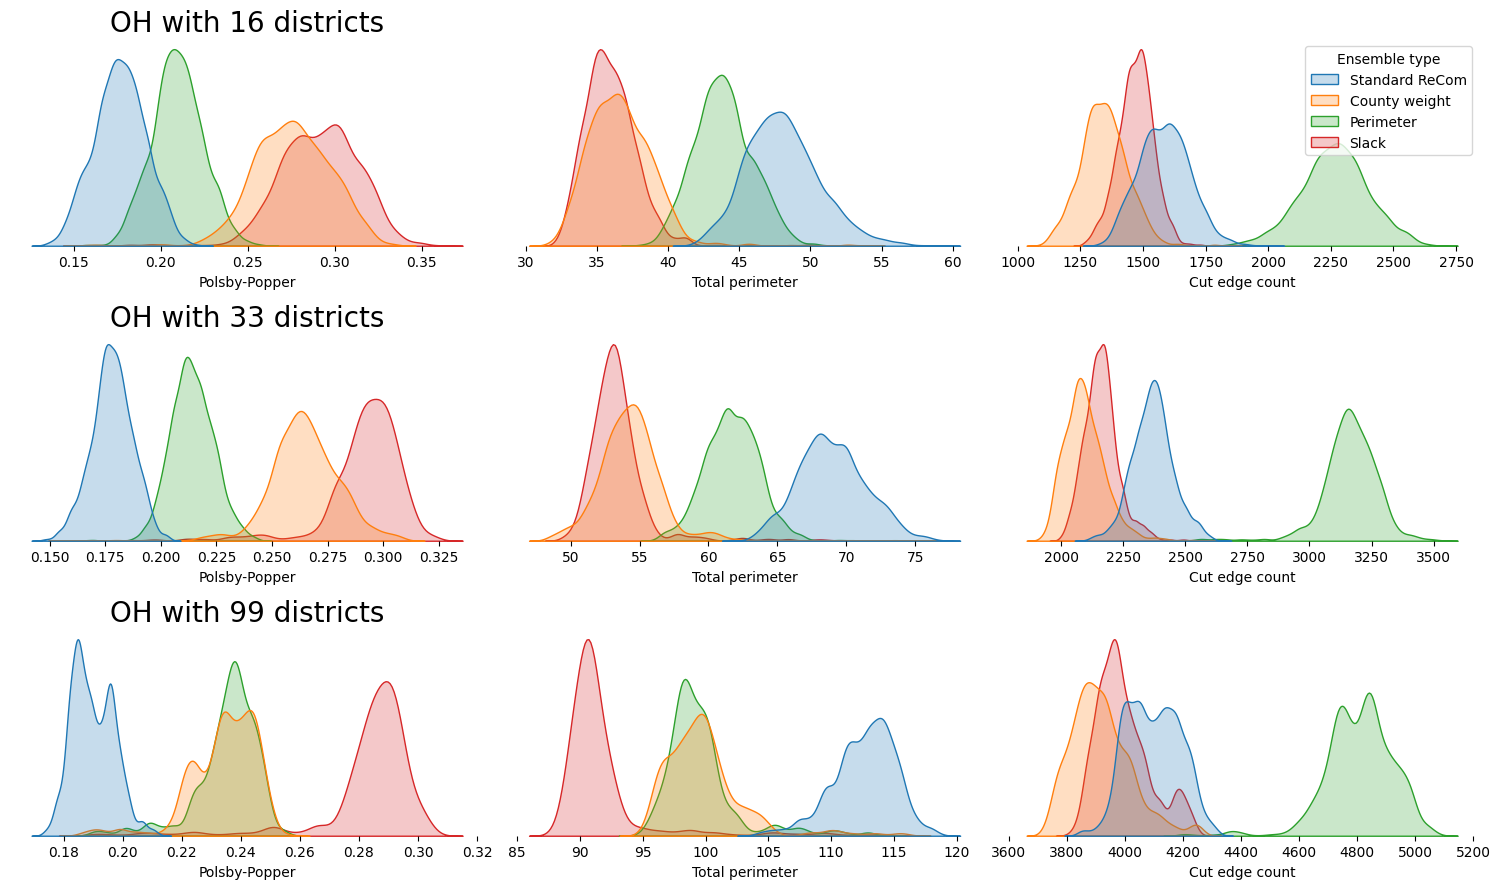

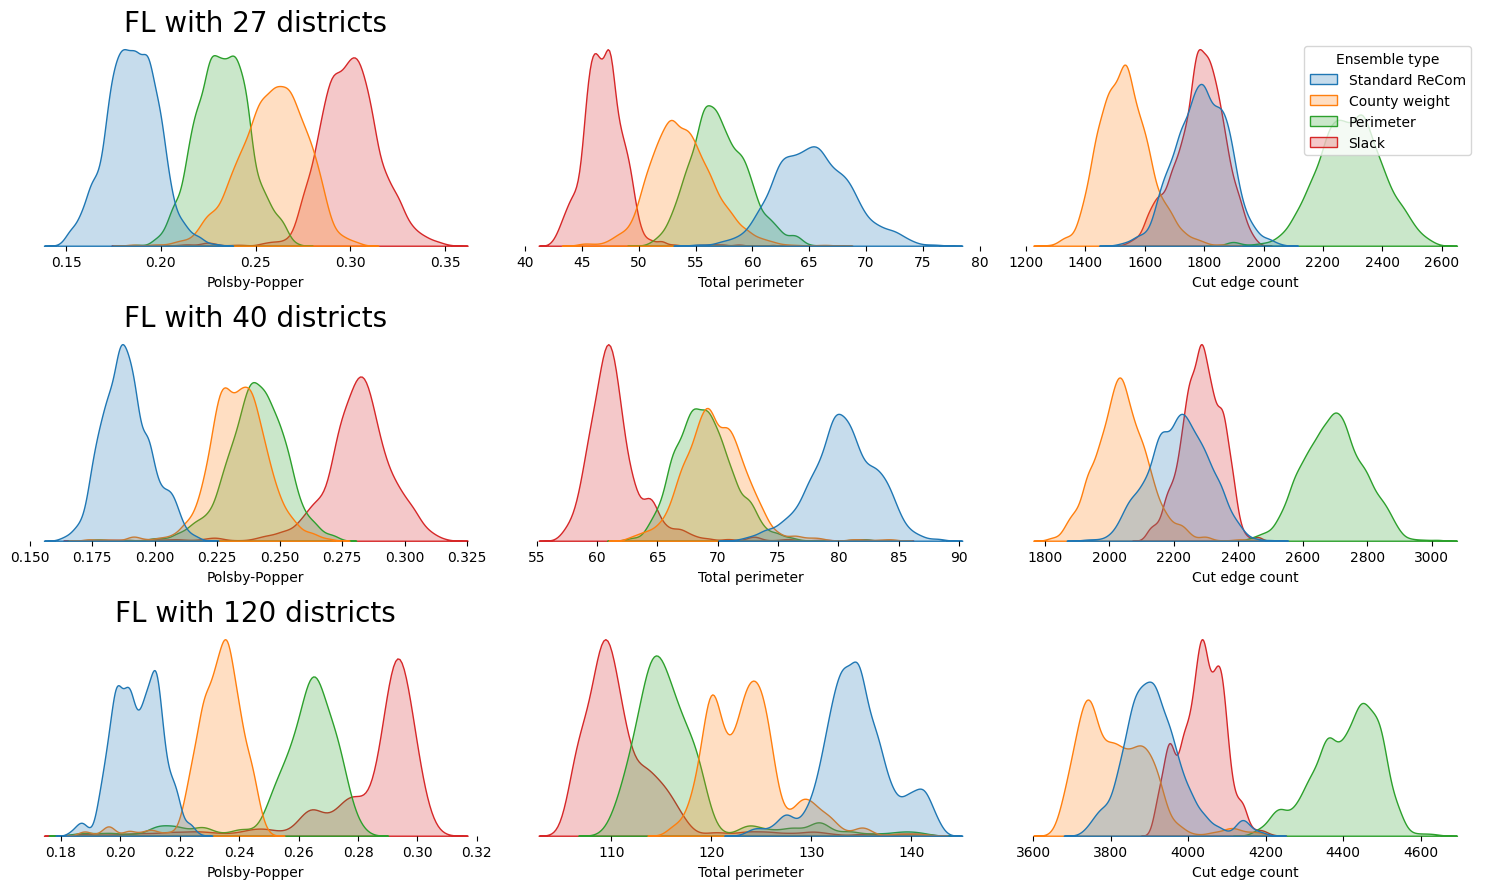

In [25]:
to_do_list = [
('37', [13, 50, 120]), # NC 
('42', [17, 50, 203]), # PA
('39', [16, 33, 99]), # OH 
('12', [27, 40, 120]), # FL congressional
]

for (fips, k_list) in to_do_list:
    Build_plot(fips, k_list, plot_type = 'plots3', size='5K', legend = True, filename = None)

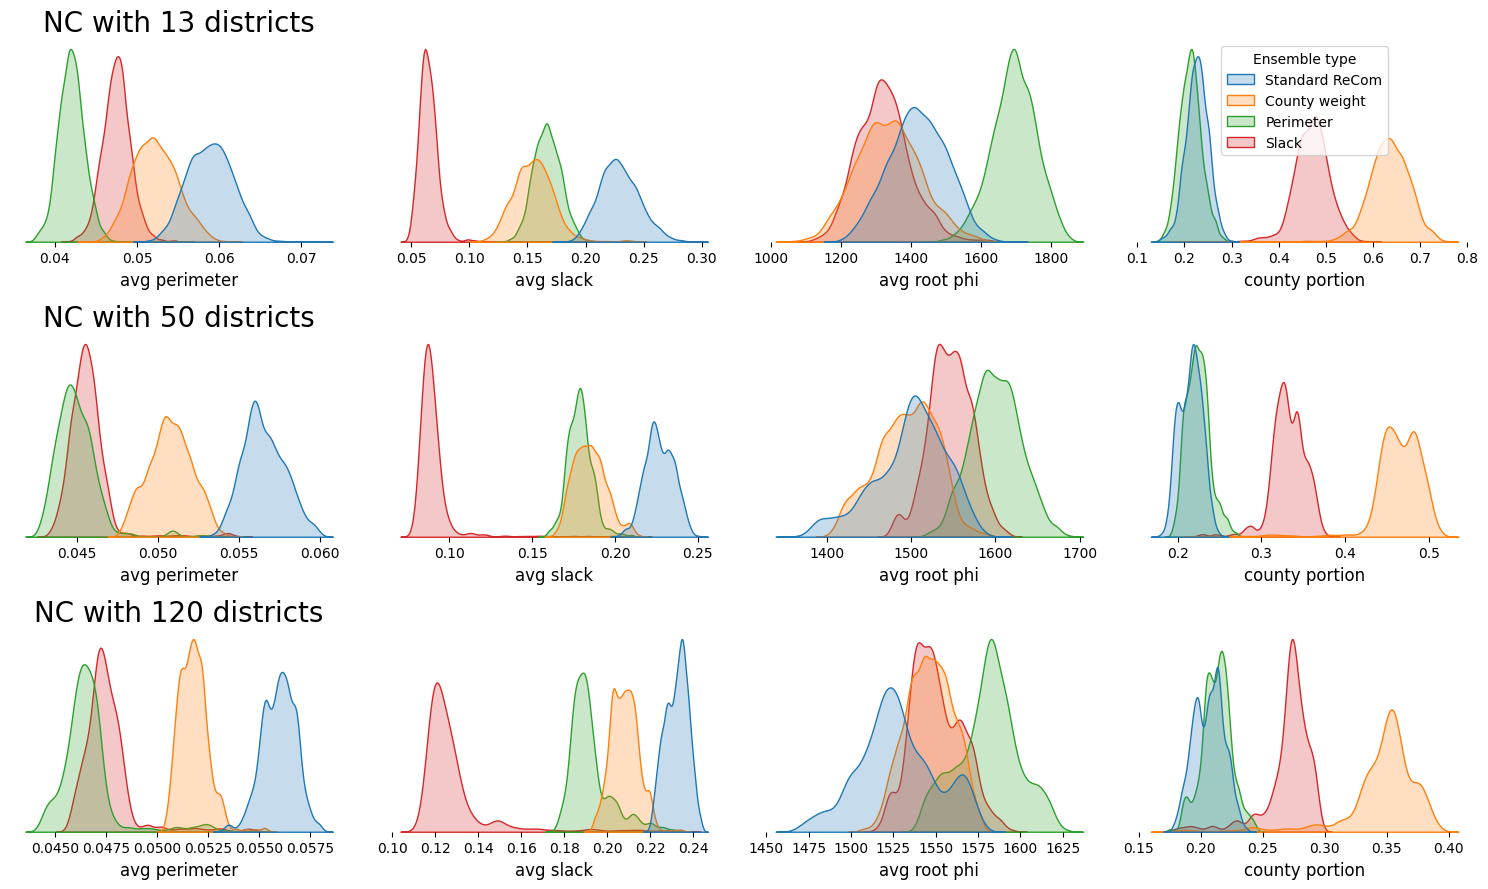

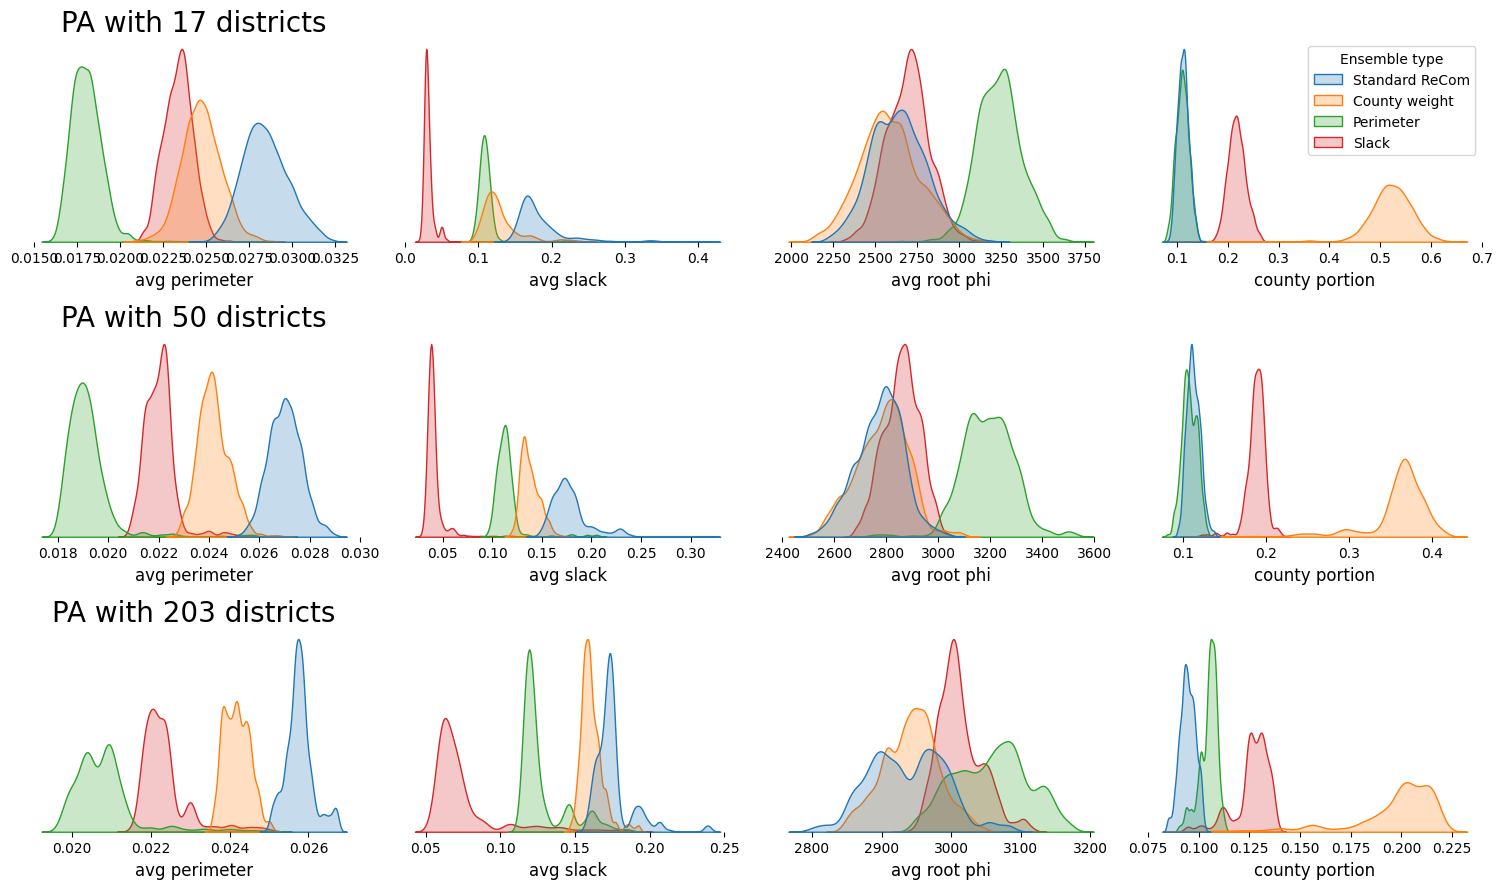

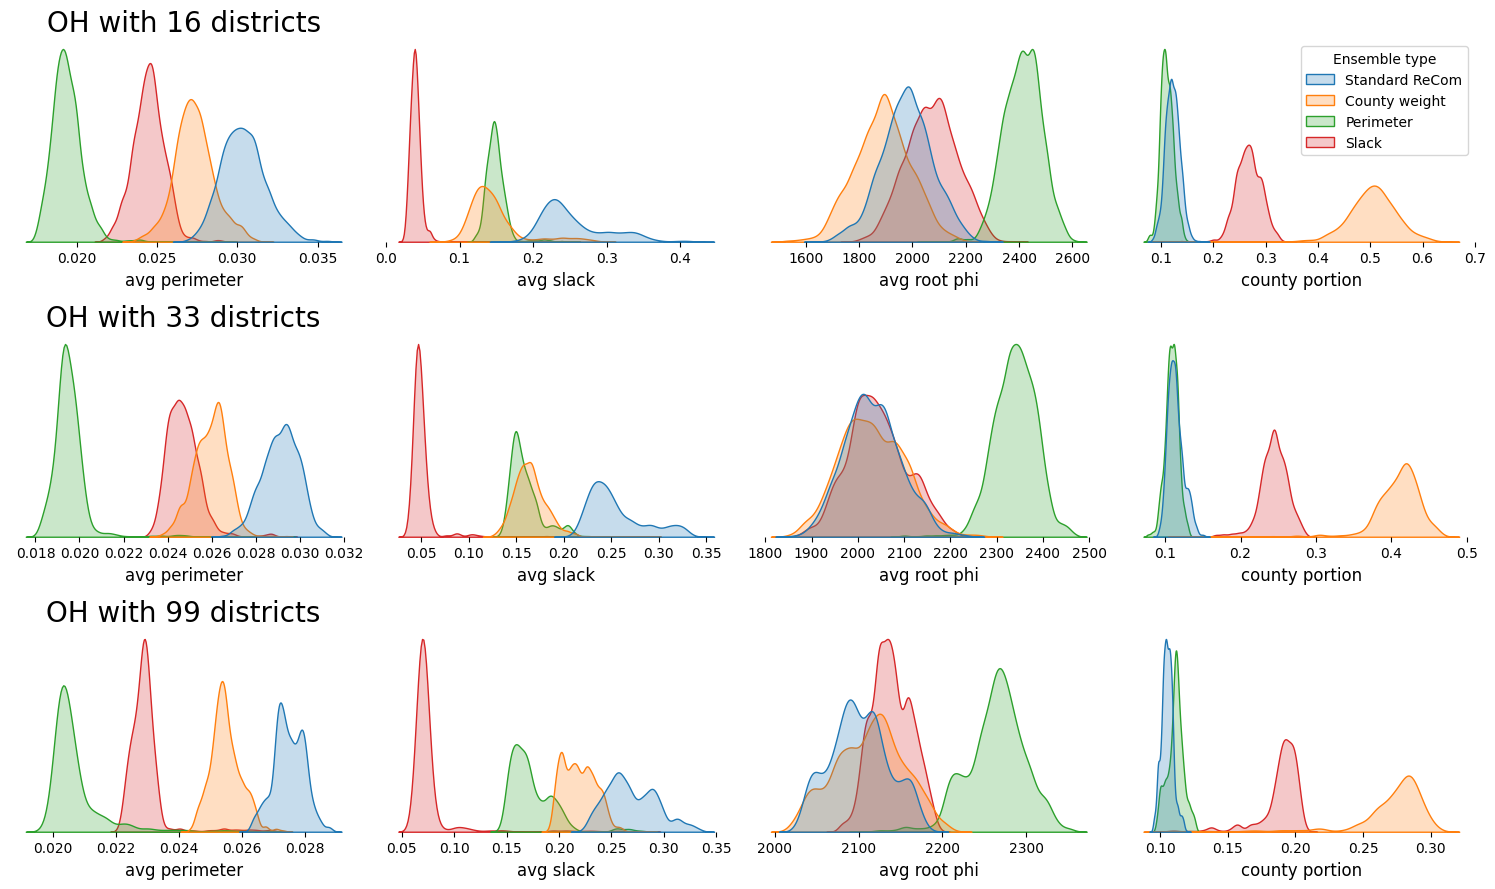

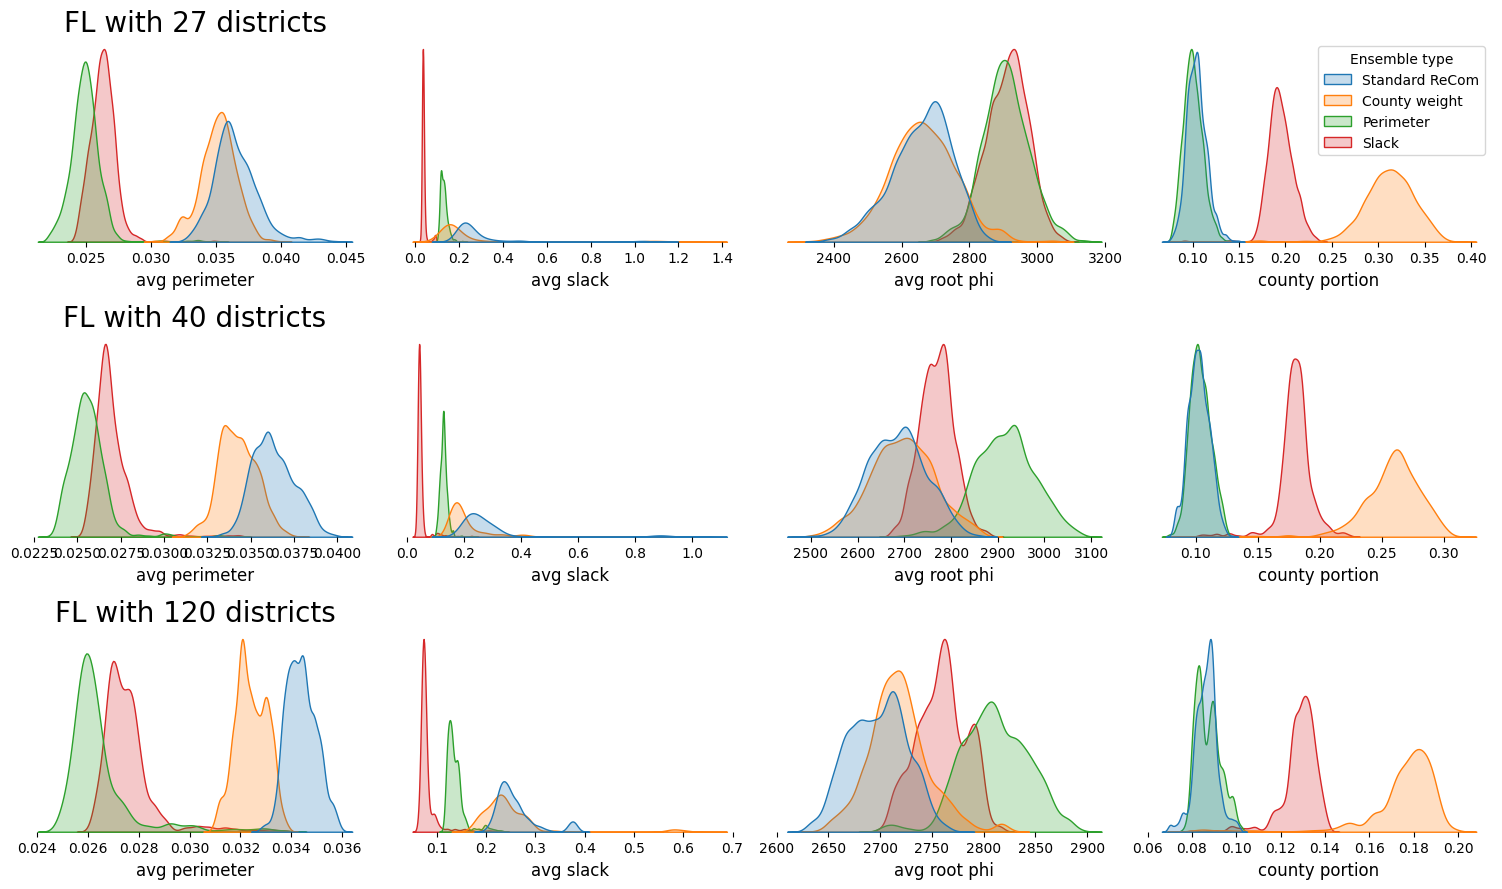

In [26]:
for (fips, k_list) in to_do_list:
    Build_plot(fips, k_list, plot_type = 'avg_plots', size='5K', legend = True, filename = None)